# Анализ и прогнозирование инвестиционной активности в субъектах РФ с использованием моделей временных рядов и ML

## 1. Импорт библиотек

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm
import itertools
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

## 2. Загрузка данных и подготовка

In [3]:
df = pd.read_csv('data.csv')
print(f"Размер исходного датасета: {df.shape}")

Размер исходного датасета: (522, 26)


In [4]:
target = 'Инвестиции, млн руб. на чел.'

train_data = df[df['Год'] <= 2022].copy()
test_data = df[df['Год'] == 2023].copy()

print(f"Размер обучающей выборки: {train_data.shape[0]} записей")
print(f"Размер тестовой выборки: {test_data.shape[0]} записей")

Размер обучающей выборки: 435 записей
Размер тестовой выборки: 87 записей


## 3. Линейные модели

In [5]:
exclude_cols = [
    'Округ', 'Регион', 'Год', 'Инвестиции в основной капитал в млн.руб',
    'RVI среднегодовое значение, пт', 'RGBITR среднегодовое значение, пт',
    'Цена фьючерса на нефть Brent, $', 'Внутренний гос. долг, млрд. руб.',
    'Военные расходы, млрд. руб.', 'Цена фьючерса на золото, $',
    'Курс Доллара к Рублю, ₽', 'Годовая инфляция, %',
    'Среднегодовая ставка ЦБ, %', 'MCFTR среднегодовое значение, пт.'
]

features = [col for col in train_data.columns if col not in exclude_cols + [target]]

print("\nИспользуемые признаки для линейных моделей:")
for feature in features:
    print(f"- {feature}")


Используемые признаки для линейных моделей:
- ВРП
- Численность населения
- Уровень безработицы от 15 д 72 лет, %
- Средняя ЗП в руб
- Всего зарегистрировано преступлений
- Оборот розничной торговли, млн.руб.
- Денежные доходы - всего, млн.руб.
- Внутренние текущие затраты на научные исследования и разработки, млн.руб
- ВРП, млн руб. на чел.
- Розничный оборот, млн руб. на чел.
- Доходы, млн руб. на чел.


In [6]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

all_models_metrics = {}
all_models_predictions = {}

In [7]:
def print_model_metrics(model_name, y_true, y_pred):
    """Вывод метрик модели"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

### 3.1 Linear Regression с Feature Engineering

In [8]:
# Linear Regression с Feature Engineering
X_train_engineered = X_train.copy()
X_test_engineered = X_test.copy()

X_train_engineered['ВРП_лог'] = np.log1p(X_train_engineered['ВРП, млн руб. на чел.'])
X_train_engineered['ЗП_квадрат'] = X_train_engineered['Средняя ЗП в руб'] ** 2
X_train_engineered['ЗП_делить_безработицу'] = X_train_engineered['Средняя ЗП в руб'] / (X_train_engineered['Уровень безработицы от 15 д 72 лет, %'] + 1)
X_train_engineered['ВРП_делить_доходы'] = X_train_engineered['ВРП, млн руб. на чел.'] / (X_train_engineered['Доходы, млн руб. на чел.'] + 1)

X_test_engineered['ВРП_лог'] = np.log1p(X_test_engineered['ВРП, млн руб. на чел.'])
X_test_engineered['ЗП_квадрат'] = X_test_engineered['Средняя ЗП в руб'] ** 2
X_test_engineered['ЗП_делить_безработицу'] = X_test_engineered['Средняя ЗП в руб'] / (X_test_engineered['Уровень безработицы от 15 д 72 лет, %'] + 1)
X_test_engineered['ВРП_делить_доходы'] = X_test_engineered['ВРП, млн руб. на чел.'] / (X_test_engineered['Доходы, млн руб. на чел.'] + 1)

scaler_engineered = StandardScaler()
X_train_engineered_scaled = scaler_engineered.fit_transform(X_train_engineered)
X_test_engineered_scaled = scaler_engineered.transform(X_test_engineered)

lr_model = LinearRegression()
lr_model.fit(X_train_engineered_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_engineered_scaled)

all_models_metrics['Linear Regression + FE'] = print_model_metrics('Linear Regression + FE', y_test, y_pred_lr)
all_models_predictions['Linear Regression + FE'] = y_pred_lr


Linear Regression + FE:
  MSE: 0.0213
  RMSE: 0.1459
  MAE: 0.0896
  R²: 0.8824


### 3.2 Ridge Regression

In [9]:
#Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

all_models_metrics['Ridge Regression'] = print_model_metrics('Ridge Regression', y_test, y_pred_ridge)
all_models_predictions['Ridge Regression'] = y_pred_ridge


Ridge Regression:
  MSE: 0.0242
  RMSE: 0.1556
  MAE: 0.0803
  R²: 0.8662


### 3.3 Lasso Regression

In [10]:
#Lasso Regression
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

all_models_metrics['Lasso Regression'] = print_model_metrics('Lasso Regression', y_test, y_pred_lasso)
all_models_predictions['Lasso Regression'] = y_pred_lasso


Lasso Regression:
  MSE: 0.0248
  RMSE: 0.1573
  MAE: 0.0852
  R²: 0.8633


### 3.4 ElasticNet

In [11]:
#ElasticNet
elasticnet_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
elasticnet_model.fit(X_train_scaled, y_train)
y_pred_elasticnet = elasticnet_model.predict(X_test_scaled)

all_models_metrics['ElasticNet'] = print_model_metrics('ElasticNet', y_test, y_pred_elasticnet)
all_models_predictions['ElasticNet'] = y_pred_elasticnet


ElasticNet:
  MSE: 0.0237
  RMSE: 0.1538
  MAE: 0.0820
  R²: 0.8693


## 4. Модели с временными рядами

In [12]:
def create_lags(df, target, features, n_lags=2):
    df_lagged = df.copy()

    for region, group in df.groupby('Регион'):
        region_idx = group.index

        # Создание лагов для целевой переменной
        for lag in range(1, n_lags + 1):
            lag_column = f'{target}_lag{lag}'
            df_lagged.loc[region_idx, lag_column] = group[target].shift(lag)

        # Создание лагов для признаков
        for feature in features:
            for lag in range(1, n_lags + 1):
                lag_column = f'{feature}_lag{lag}'
                df_lagged.loc[region_idx, lag_column] = group[feature].shift(lag)

    df_lagged = df_lagged.dropna()
    return df_lagged

In [13]:
lag_features = [
    'ВРП, млн руб. на чел.',
    'Средняя ЗП в руб',
    'Доходы, млн руб. на чел.',
    'Уровень безработицы от 15 д 72 лет, %'
]

train_lagged = create_lags(train_data, target, lag_features, n_lags=2)

base_features = [
    'ВРП, млн руб. на чел.',
    'Средняя ЗП в руб',
    'Уровень безработицы от 15 д 72 лет, %'
]

features_with_lags = base_features.copy()
for lag in range(1, 3):
    features_with_lags.append(f'{target}_lag{lag}')
    for feature in lag_features:
        features_with_lags.append(f'{feature}_lag{lag}')

features_with_lags = list(set(features_with_lags))

In [14]:
X_train_lagged = train_lagged[features_with_lags]
y_train_lagged = train_lagged[target]

test_lagged = test_data.copy()
for region in test_data['Регион'].unique():
    region_data = df[(df['Регион'] == region) & (df['Год'].isin([2021, 2022]))]
    if len(region_data) >= 2:
        test_lagged.loc[test_lagged['Регион'] == region, f'{target}_lag1'] = region_data[region_data['Год'] == 2022][target].values[0]
        test_lagged.loc[test_lagged['Регион'] == region, f'{target}_lag2'] = region_data[region_data['Год'] == 2021][target].values[0]

        for feature in lag_features:
            test_lagged.loc[test_lagged['Регион'] == region, f'{feature}_lag1'] = region_data[region_data['Год'] == 2022][feature].values[0]
            test_lagged.loc[test_lagged['Регион'] == region, f'{feature}_lag2'] = region_data[region_data['Год'] == 2021][feature].values[0]

test_lagged = test_lagged.dropna(subset=features_with_lags)
X_test_lagged = test_lagged[features_with_lags]
y_test_lagged = test_lagged[target]

print(f"\nРазмер обучающей выборки с лагами: {X_train_lagged.shape[0]}")
print(f"Размер тестовой выборки с лагами: {X_test_lagged.shape[0]}")


Размер обучающей выборки с лагами: 261
Размер тестовой выборки с лагами: 87


### 4.1 Linear Regression с лагами

In [15]:
#Linear Regression с лагами
model_lagged = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model_lagged.fit(X_train_lagged, y_train_lagged)
y_pred_lagged = model_lagged.predict(X_test_lagged)

all_models_metrics['Linear Regression (с лагами)'] = print_model_metrics('Linear Regression (с лагами)', y_test_lagged, y_pred_lagged)
all_models_predictions['Linear Regression (с лагами)'] = y_pred_lagged


Linear Regression (с лагами):
  MSE: 0.0047
  RMSE: 0.0682
  MAE: 0.0304
  R²: 0.9743


### 4.2 ARIMA модель

In [16]:
#ARIMA модель
def fit_arima_by_region(train_data, test_data, target):
    predictions = []
    actuals = []

    for region in test_data['Регион'].unique():
        region_train = train_data[train_data['Регион'] == region].sort_values('Год')
        region_test = test_data[test_data['Регион'] == region]

        if len(region_train) >= 3:
            try:
                series = region_train[target].values

                model = ARIMA(series, order=(1, 0, 0))
                fitted_model = model.fit()

                forecast = fitted_model.forecast(steps=1)
                predictions.append(forecast[0])
                actuals.append(region_test[target].values[0])

            except Exception as e:
                predictions.append(series[-1])
                actuals.append(region_test[target].values[0])
                continue

    return np.array(predictions), np.array(actuals)

arima_predictions, arima_actuals = fit_arima_by_region(train_data, test_data, target)

if len(arima_predictions) > 0:
    all_models_metrics['ARIMA'] = print_model_metrics('ARIMA', arima_actuals, arima_predictions)
    all_models_predictions['ARIMA'] = arima_predictions
else:
    print("ARIMA: Не удалось обучить модель")

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA:
  MSE: 0.0094
  RMSE: 0.0970
  MAE: 0.0628
  R²: 0.9480


### 4.3 Цепи Маркова

In [17]:
#Цепи Маркова
class MarkovChainForecaster:
    def __init__(self, n_states=3, method='gmm'):
        self.n_states = n_states
        self.method = method
        self.transition_matrix = None
        self.state_means = None
        self.state_bounds = None
        self.states = None

    def _discretize(self, series):
        """Дискретизация непрерывной переменной в состояния"""
        if self.method == 'quantile':
            quantiles = np.linspace(0, 1, self.n_states + 1)
            thresholds = np.quantile(series, quantiles[1:-1])
            states = np.digitize(series, thresholds)
            bounds = thresholds

        elif self.method == 'gmm':
            gmm = GaussianMixture(n_components=self.n_states, random_state=42)
            gmm.fit(series.reshape(-1, 1))
            states = gmm.predict(series.reshape(-1, 1))

            means = gmm.means_.flatten()
            order = np.argsort(means)
            mapping = {old: new for new, old in enumerate(order)}
            states = np.array([mapping[s] for s in states])
            bounds = None

        else:
            min_val, max_val = series.min(), series.max()
            thresholds = np.linspace(min_val, max_val, self.n_states + 1)[1:-1]
            states = np.digitize(series, thresholds)
            bounds = thresholds

        return states, bounds

    def _estimate_transition_matrix(self, states):
        """Оценка матрицы переходных вероятностей"""
        n = self.n_states
        transition_counts = np.zeros((n, n))

        for i in range(len(states) - 1):
            from_state = states[i]
            to_state = states[i + 1]
            transition_counts[from_state, to_state] += 1

        row_sums = transition_counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        transition_matrix = transition_counts / row_sums

        transition_matrix = 0.9 * transition_matrix + 0.1 * (1 / n)

        return transition_matrix

    def fit(self, series):
        """
        Обучение модели на временном ряде
        """
        states, bounds = self._discretize(series)
        self.states = states

        if bounds is not None:
            self.state_bounds = bounds

        self.state_means = np.array([series[states == i].mean() for i in range(self.n_states)])

        self.transition_matrix = self._estimate_transition_matrix(states)
        self.fitted_series = series

        return self

    def forecast(self, current_value=None, steps=1, method='most_likely'):
        """
        Прогнозирование непрерывного значения
        """
        if hasattr(self, 'fitted_series'):
            series_for_state = self.fitted_series
        else:
            series_for_state = np.array([])

        if current_value is not None:
            series_for_state = np.append(series_for_state, current_value)

        if len(series_for_state) > 0:
            if self.method == 'gmm':
                temp_states, _ = self._discretize(series_for_state)
                current_state = temp_states[-1]
            else:
                if self.method == 'quantile':
                    quantiles = np.linspace(0, 1, self.n_states + 1)
                    thresholds = np.quantile(series_for_state, quantiles[1:-1])
                    current_state = np.digitize([current_value], thresholds)[0]
                else:
                    min_val, max_val = series_for_state.min(), series_for_state.max()
                    thresholds = np.linspace(min_val, max_val, self.n_states + 1)[1:-1]
                    current_state = np.digitize([current_value], thresholds)[0]
        else:
            current_state = self.states[-1] if hasattr(self, 'states') else 0

        predictions = []
        current_state_pred = current_state

        for _ in range(steps):
            if method == 'most_likely':
                next_state = np.argmax(self.transition_matrix[current_state_pred])
            else:
                probabilities = self.transition_matrix[current_state_pred]
                next_state = np.random.choice(self.n_states, p=probabilities)

            if method == 'weighted':
                probabilities = self.transition_matrix[current_state_pred]
                pred_value = np.sum(probabilities * self.state_means)
            else:
                pred_value = self.state_means[next_state]

            predictions.append(pred_value)
            current_state_pred = next_state

        return np.array(predictions)

def fit_markov_chain_by_region(train_data, test_data, target, n_states=4, method='quantile'):
    """
    Обучение модели Марковских цепей для каждого региона
    """
    predictions = []
    actuals = []
    regions = []

    for region in test_data['Регион'].unique():
        region_train = train_data[train_data['Регион'] == region].sort_values('Год')
        region_test = test_data[test_data['Регион'] == region]

        if len(region_train) >= 3:
            try:
                series = region_train[target].values

                mc_model = MarkovChainForecaster(n_states=n_states, method=method)
                mc_model.fit(series)

                last_value = series[-1]

                forecast = mc_model.forecast(current_value=last_value, steps=1, method='most_likely')

                predictions.append(forecast[0])
                actuals.append(region_test[target].values[0])
                regions.append(region)

            except Exception as e:
                predictions.append(series[-1])
                actuals.append(region_test[target].values[0])
                regions.append(region)
                continue

    return np.array(predictions), np.array(actuals), regions

try:
    markov_predictions, markov_actuals, markov_regions = fit_markov_chain_by_region(
        train_data, test_data, target,
        n_states=4,
        method='quantile'
    )

    if len(markov_predictions) > 0:
        all_models_metrics['Markov Chain'] = print_model_metrics('Markov Chain', markov_actuals, markov_predictions)
        all_models_predictions['Markov Chain'] = markov_predictions

    else:
        print("Markov Chain: Не удалось обучить модель")

except Exception as e:
    print(f"Markov Chain: Ошибка - {e}")


Markov Chain:
  MSE: 0.0130
  RMSE: 0.1139
  MAE: 0.0685
  R²: 0.9284


## 5. Нейросетевые модели

In [18]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_nn = scaler_x.fit_transform(X_train_lagged)
X_test_nn = scaler_x.transform(X_test_lagged)
y_train_nn = scaler_y.fit_transform(y_train_lagged.values.reshape(-1, 1)).flatten()

### 5.1 N-BEATS

In [19]:
#N-BEATS
class SimpleNBeats(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3):
        super(SimpleNBeats, self).__init__()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())

        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(hidden_size, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def train_nbeats(X_train, y_train, X_test, epochs=100, lr=0.001):
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)

    input_size = X_train.shape[1]
    model = SimpleNBeats(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy().flatten()

    return predictions

try:
    nbeats_predictions_scaled = train_nbeats(X_train_nn, y_train_nn, X_test_nn, epochs=200)
    nbeats_predictions = scaler_y.inverse_transform(nbeats_predictions_scaled.reshape(-1, 1)).flatten()

    all_models_metrics['N-BEATS'] = print_model_metrics('N-BEATS', y_test_lagged, nbeats_predictions)
    all_models_predictions['N-BEATS'] = nbeats_predictions
except Exception as e:
    print(f"N-BEATS: Ошибка - {e}")


N-BEATS:
  MSE: 0.0054
  RMSE: 0.0734
  MAE: 0.0389
  R²: 0.9702


### 5.2 Temporal Fusion Transformer


In [20]:
#TFT
class SimpleTFT(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.1):
        super(SimpleTFT, self).__init__()

        self.encoder = nn.LSTM(input_size, hidden_size, num_layers,
                              batch_first=True, dropout=dropout)

        self.decoder_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        ])

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, (hidden, cell) = self.encoder(x)
        context = lstm_out.mean(dim=1)

        x = context
        for layer in self.decoder_layers:
            x = layer(x)

        return x.squeeze()

def train_tft(X_train, y_train, X_test, epochs=150, lr=0.001):
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)

    input_size = X_train.shape[1]
    model = SimpleTFT(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()

    return predictions

try:
    tft_predictions = train_tft(X_train_nn, y_train_nn, X_test_nn, epochs=200)
    tft_predictions = scaler_y.inverse_transform(tft_predictions.reshape(-1, 1)).flatten()

    all_models_metrics['TFT'] = print_model_metrics('TFT', y_test_lagged, tft_predictions)
    all_models_predictions['TFT'] = tft_predictions
except Exception as e:
    print(f"TFT: Ошибка - {e}")


TFT:
  MSE: 0.0076
  RMSE: 0.0871
  MAE: 0.0401
  R²: 0.9581


## 6. Градиентные бустинги

### 6.1 Gradient boosting

In [21]:
#Gradient Boosting
X_train_gb = X_train_scaled
X_test_gb = X_test_scaled
y_train_gb = y_train
y_test_gb = y_test

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    subsample=0.8
)

gb_model.fit(X_train_gb, y_train_gb)
y_pred_gb = gb_model.predict(X_test_gb)

all_models_metrics['Gradient Boosting'] = print_model_metrics(
    'Gradient Boosting (sklearn)',
    y_test_gb,
    y_pred_gb
)
all_models_predictions['Gradient Boosting'] = y_pred_gb


Gradient Boosting (sklearn):
  MSE: 0.0318
  RMSE: 0.1782
  MAE: 0.0864
  R²: 0.8246


### 6.2 HistGradientBoosting

In [22]:
#HistGradientBoosting
hist_gb_model = HistGradientBoostingRegressor(
    max_iter=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

hist_gb_model.fit(X_train_gb, y_train_gb)
y_pred_hist_gb = hist_gb_model.predict(X_test_gb)

all_models_metrics['HistGradient Boosting'] = print_model_metrics(
    'HistGradient Boosting',
    y_test_gb,
    y_pred_hist_gb
)
all_models_predictions['HistGradient Boosting'] = y_pred_hist_gb


HistGradient Boosting:
  MSE: 0.0357
  RMSE: 0.1890
  MAE: 0.0991
  R²: 0.8026


### 6.3 XGBoost

In [23]:
#XGBoost
try:
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        subsample=0.8,
        colsample_bytree=0.8
    )

    xgb_model.fit(X_train_gb, y_train_gb)
    y_pred_xgb = xgb_model.predict(X_test_gb)

    all_models_metrics['XGBoost'] = print_model_metrics('XGBoost', y_test_gb, y_pred_xgb)
    all_models_predictions['XGBoost'] = y_pred_xgb

except Exception as e:
    print(f"XGBoost: Ошибка - {e}")


XGBoost:
  MSE: 0.0204
  RMSE: 0.1428
  MAE: 0.0791
  R²: 0.8874


### 6.4 LightGBM

In [24]:
#LightGBM
try:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=-1
    )

    lgb_model.fit(X_train_gb, y_train_gb)
    y_pred_lgb = lgb_model.predict(X_test_gb)

    all_models_metrics['LightGBM'] = print_model_metrics('LightGBM', y_test_gb, y_pred_lgb)
    all_models_predictions['LightGBM'] = y_pred_lgb

except Exception as e:
    print(f"LightGBM: Ошибка - {e}")


LightGBM:
  MSE: 0.0378
  RMSE: 0.1945
  MAE: 0.1042
  R²: 0.7910


### 6.5 CatBoost

In [25]:
#CatBoost
try:
    catboost_model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=3,
        random_state=42,
        verbose=False
    )

    catboost_model.fit(X_train_gb, y_train_gb)
    y_pred_catboost = catboost_model.predict(X_test_gb)

    all_models_metrics['CatBoost'] = print_model_metrics('CatBoost', y_test_gb, y_pred_catboost)
    all_models_predictions['CatBoost'] = y_pred_catboost

except Exception as e:
    print(f"CatBoost: Ошибка - {e}")


CatBoost:
  MSE: 0.0217
  RMSE: 0.1474
  MAE: 0.0861
  R²: 0.8800


### 6.6 Градиентный бустинг с лагами

In [26]:
#Градиентный бустинг с лагами
X_train_gb_lagged = scaler_x.fit_transform(X_train_lagged) if 'scaler_x' in locals() else StandardScaler().fit_transform(X_train_lagged)
X_test_gb_lagged = scaler_x.transform(X_test_lagged) if 'scaler_x' in locals() else StandardScaler().fit_transform(X_test_lagged)
y_train_gb_lagged = y_train_lagged
y_test_gb_lagged = y_test_lagged

gb_lagged_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    subsample=0.8
)

gb_lagged_model.fit(X_train_gb_lagged, y_train_gb_lagged)
y_pred_gb_lagged = gb_lagged_model.predict(X_test_gb_lagged)

all_models_metrics['Gradient Boosting (с лагами)'] = print_model_metrics(
    'Gradient Boosting (с лагами)',
    y_test_gb_lagged,
    y_pred_gb_lagged
)
all_models_predictions['Gradient Boosting (с лагами)'] = y_pred_gb_lagged


Gradient Boosting (с лагами):
  MSE: 0.0062
  RMSE: 0.0787
  MAE: 0.0419
  R²: 0.9658


## Сравнение моделей

In [27]:
#Сравнение всех моделей
comparison_data = []
for model_name, metrics in all_models_metrics.items():
    comparison_data.append({
        'Модель': model_name,
        'MSE': metrics['MSE'],
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE')

print("\nСравнение всех моделей:")
print(comparison_df.to_string(index=False))


Сравнение всех моделей:
                      Модель      MSE     RMSE      MAE       R²
Linear Regression (с лагами) 0.004652 0.068206 0.030446 0.974310
                     N-BEATS 0.005387 0.073398 0.038857 0.970250
Gradient Boosting (с лагами) 0.006191 0.078681 0.041894 0.965812
                         TFT 0.007591 0.087127 0.040095 0.958080
                       ARIMA 0.009418 0.097048 0.062818 0.947989
                Markov Chain 0.012969 0.113879 0.068460 0.928383
                     XGBoost 0.020397 0.142819 0.079061 0.887359
      Linear Regression + FE 0.021287 0.145901 0.089568 0.882445
                    CatBoost 0.021729 0.147406 0.086075 0.880007
                  ElasticNet 0.023669 0.153848 0.081978 0.869290
            Ridge Regression 0.024222 0.155635 0.080270 0.866237
            Lasso Regression 0.024750 0.157323 0.085167 0.863319
           Gradient Boosting 0.031767 0.178232 0.086379 0.824573
       HistGradient Boosting 0.035739 0.189047 0.099118 0.802638


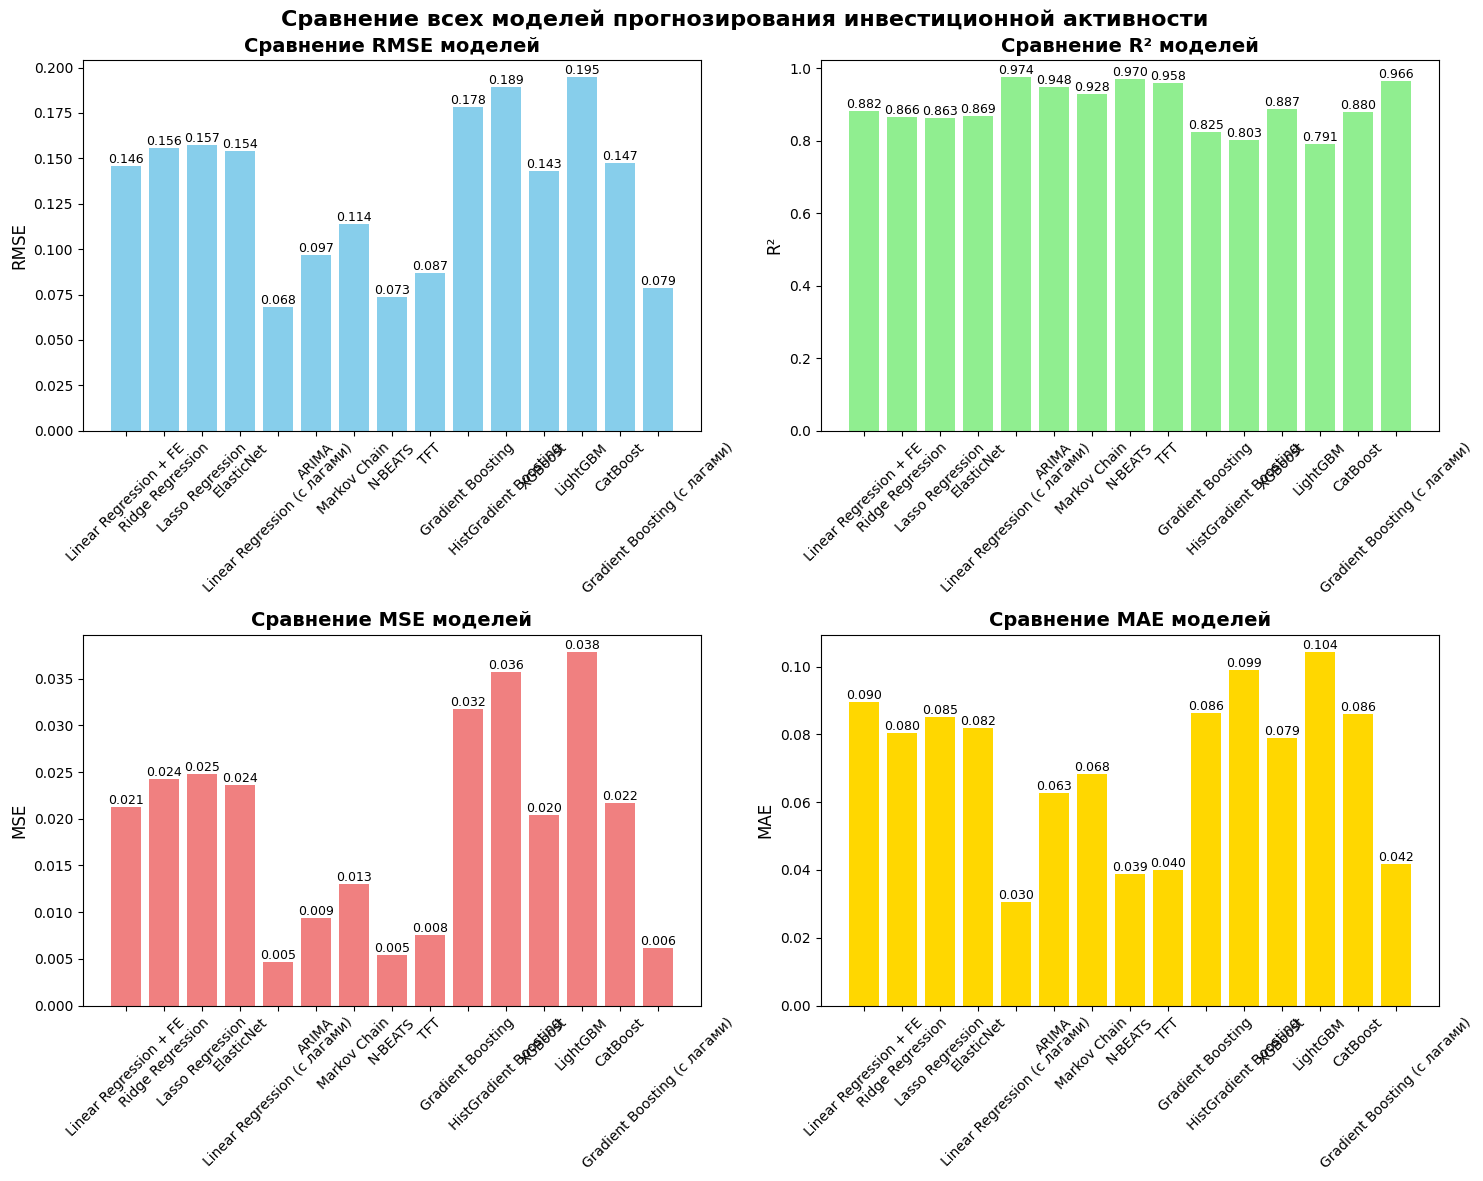

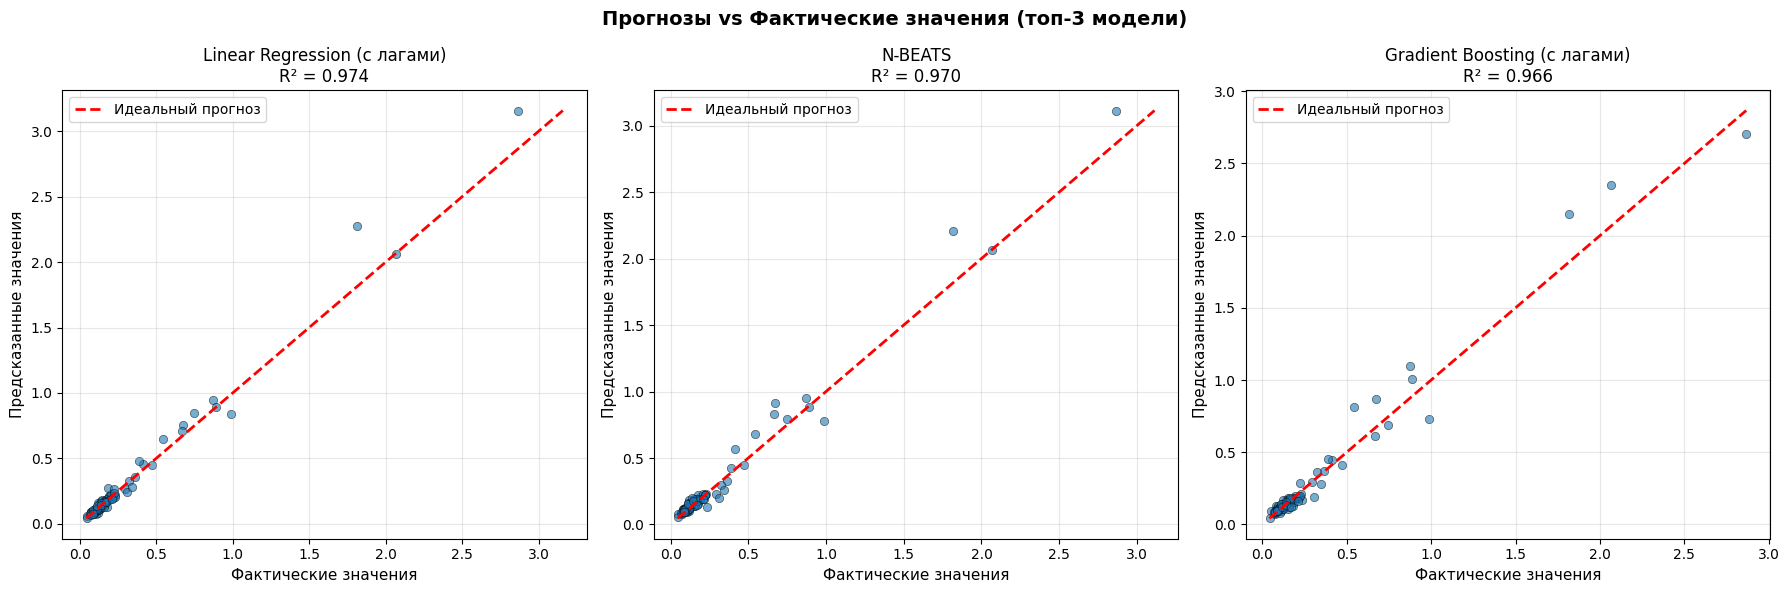

In [28]:
#Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Сравнение RMSE
models_available = [model for model in all_models_metrics.keys()]
rmse_values = [all_models_metrics[model]['RMSE'] for model in models_available]

bars1 = axes[0, 0].bar(models_available, rmse_values, color='skyblue')
axes[0, 0].set_title('Сравнение RMSE моделей', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Сравнение R²
r2_values = [all_models_metrics[model]['R2'] for model in models_available]

bars2 = axes[0, 1].bar(models_available, r2_values, color='lightgreen')
axes[0, 1].set_title('Сравнение R² моделей', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('R²', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Сравнение MSE
mse_values = [all_models_metrics[model]['MSE'] for model in models_available]

bars3 = axes[1, 0].bar(models_available, mse_values, color='lightcoral')
axes[1, 0].set_title('Сравнение MSE моделей', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MSE', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Сравнение MAE
mae_values = [all_models_metrics[model]['MAE'] for model in models_available]

bars4 = axes[1, 1].bar(models_available, mae_values, color='gold')
axes[1, 1].set_title('Сравнение MAE моделей', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('MAE', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
for bar in bars4:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Сравнение всех моделей прогнозирования инвестиционной активности', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('models_comparison_all.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ### График прогнозов vs фактические значения

# %%
# Выбор нескольких лучших моделей для визуализации прогнозов
top_models = comparison_df.head(3)['Модель'].tolist()

fig, axes = plt.subplots(1, len(top_models), figsize=(18, 6))
if len(top_models) == 1:
    axes = [axes]

for idx, model_name in enumerate(top_models):
    if model_name in all_models_predictions:
        if model_name in ['ARIMA', 'Markov Chain']:
            # Для моделей, работающих по регионам отдельно
            y_pred = all_models_predictions[model_name]
            if model_name == 'ARIMA':
                y_true = arima_actuals
            else:
                y_true = markov_actuals
        else:
            # Для моделей, работающих на полных данных
            y_pred = all_models_predictions[model_name]
            y_true = y_test_lagged if 'лаги' in model_name else y_test

        axes[idx].scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)

        # Линия идеального прогноза
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальный прогноз')

        axes[idx].set_xlabel('Фактические значения', fontsize=11)
        axes[idx].set_ylabel('Предсказанные значения', fontsize=11)
        axes[idx].set_title(f'{model_name}\nR² = {all_models_metrics[model_name]["R2"]:.3f}', fontsize=12)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Прогнозы vs Фактические значения (топ-3 модели)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()

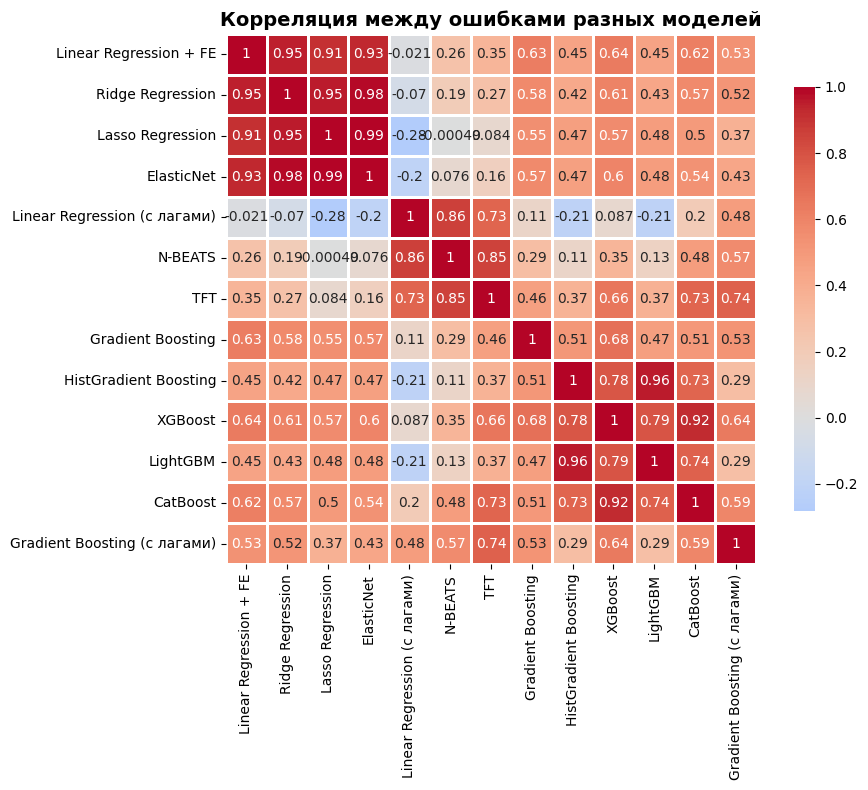

In [29]:
#Тепловая карта корреляций ошибок моделей
predictions_df = pd.DataFrame()

for model_name in all_models_predictions:
    if model_name not in ['ARIMA', 'Markov Chain']:
        predictions_df[model_name] = all_models_predictions[model_name]

if len(predictions_df.columns) > 1:
    errors_df = predictions_df.copy()
    for model in predictions_df.columns:
        if model in ['Linear Regression + FE', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']:
            errors_df[model] = predictions_df[model] - y_test.values
        else:
            errors_df[model] = predictions_df[model] - y_test_lagged.values

    error_correlation = errors_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(error_correlation, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Корреляция между ошибками разных моделей', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('errors_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()


# Заключение

В ходе исследования была проведена комплексная оценка различных алгоритмов машинного обучения для прогнозирования инвестиционной активности в регионах России.

Применение методов, учитывающих временные лаги (например, Linear Regression с лагами, Gradient Boosting с лагами), показало значительное улучшение качества прогнозирования. Модели, использующие временные ряды, продемонстрировали существенно более высокие значения метрик R² и более низкие ошибки (RMSE, MAE) по сравнению с базовыми линейными методами. Это подтверждает гипотезу о важности учета временной динамики в данных.

Базовые линейные алгоритмы (Linear Regression, Ridge, Lasso, ElasticNet) показали относительно низкую точность по сравнению с более сложными методами. Их результаты оказались недостаточными для решения поставленной задачи, что исключает их из дальнейшего рассмотрения в рамках проекта. Также применение линейных данных в рамках данного проекта неактуально и неинтересно.

Нейросетевые архитектуры (N-BEATS, TFT) также показали конкурентные результаты, особенно в сочетании с признаками временных рядов. Однако их вычислительная сложность и требования к данным могут ограничивать их применение в условиях ограниченных ресурсов.

Среди всех протестированных подходов наибольший потенциал показали алгоритмы градиентного бустинга, особенно при использовании временных лагов. Эти модели продемонстрировали высокую точность и устойчивость, что делает их перспективными для дальнейшей оптимизации и интеграции в систему прогнозирования.

На основе полученных результатов рекомендуется сконцентрироваться на развитии методов градиентного бустинга с использованием временных признаков. Дальнейшая работа может включать:

* Оптимизацию гиперпараметров моделей,

* Расширение набора признаков за счёт внешних экономических индикаторов,

* Исследование ансамблевых подходов для повышения точности прогнозов.

